# Proyek Analisis Data: Air Quality Dataset (Beijing, 2013-2017)

- Nama: Ninditya Salma Nur Aini  
- Email: ninditya.sna025@gmail.com  
- ID Dicoding: ninditya_sna


## Menentukan Pertanyaan Bisnis

1. Pertanyaan Bisnis 1: Area mana yang memerlukan intervensi prioritas berdasarkan tingkat polusi PM2.5 dan gas polutan, serta bagaimana tren perbaikannya dari waktu ke waktu?
2. Pertanyaan Bisnis 2: Kapan waktu-waktu kritis yang perlu menjadi fokus pengawasan emisi dan perlindungan kesehatan masyarakat?
3. Pertanyaan Analisis Lanjutan 1 (tanpa ML): Faktor meteorologi apa yang paling berkontribusi terhadap peningkatan risiko polusi, sehingga bisa dijadikan indikator peringatan dini?
4. Pertanyaan Analisis Lanjutan 2 - AQI Multi-Polutan (tanpa ML): Polutan apa yang menjadi penyebab utama penurunan kualitas udara, dan bagaimana prioritas pengendaliannya berdasarkan tingkat risikonya?


## Import Semua Pustaka yang Digunakan

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium

from IPython.display import display

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

## Penyiapan Data

### Pengumpulan Data

In [131]:
data_path = "data/air_quality_hourly_all_stations.csv"
df = pd.read_csv(data_path)

print("Shape:", df.shape)
display(df.head())

Shape: (420768, 18)


,datetime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [132]:
summary_meta = pd.DataFrame({
    "metric": ["Jumlah stasiun", "Jumlah baris", "Tanggal awal", "Tanggal akhir"],
    "value": [
        df["station"].nunique(),
        len(df),
        pd.to_datetime(df["datetime"]).min(),
        pd.to_datetime(df["datetime"]).max(),
    ],
})

display(summary_meta)

obs_station = (
    df["station"].value_counts()
    .sort_index()
    .rename_axis("station")
    .reset_index(name="n_obs")
)
display(obs_station)

,metric,value
0,Jumlah stasiun,12
1,Jumlah baris,420768
2,Tanggal awal,2013-03-01 00:00:00
3,Tanggal akhir,2017-02-28 23:00:00


,station,n_obs
0,Aotizhongxin,35064
1,Changping,35064
2,Dingling,35064
3,Dongsi,35064
4,Guanyuan,35064
5,Gucheng,35064
6,Huairou,35064
7,Nongzhanguan,35064
8,Shunyi,35064
9,Tiantan,35064


Insight:
- Dataset mencakup 12 stasiun dan 420.768 baris data per jam.
- Rentang waktu pengamatan adalah 2013-03-01 00:00:00 hingga 2017-02-28 23:00:00.
- Jumlah observasi antarstasiun seimbang, sehingga perbandingan antarlokasi cukup fair.


### Penilaian Data

In [133]:
df.info()

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(3)
missing_table = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})

display(missing_table)

dup_count = df.duplicated().sum()
print("Jumlah baris duplikat:", dup_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   datetime  420768 non-null  object 
 1   year      420768 non-null  int64  
 2   month     420768 non-null  int64  
 3   day       420768 non-null  int64  
 4   hour      420768 non-null  int64  
 5   PM2.5     412029 non-null  float64
 6   PM10      414319 non-null  float64
 7   SO2       411747 non-null  float64
 8   NO2       408652 non-null  float64
 9   CO        400067 non-null  float64
 10  O3        407491 non-null  float64
 11  TEMP      420370 non-null  float64
 12  PRES      420375 non-null  float64
 13  DEWP      420365 non-null  float64
 14  RAIN      420378 non-null  float64
 15  wd        418946 non-null  object 
 16  WSPM      420450 non-null  float64
 17  station   420768 non-null  object 
dtypes: float64(11), int64(4), object(3)
memory usage: 57.8+ MB


,missing_count,missing_pct
CO,20701,4.920
O3,13277,3.155
NO2,12116,2.879
SO2,9021,2.144
PM2.5,8739,2.077
PM10,6449,1.533
wd,1822,0.433
DEWP,403,0.096
TEMP,398,0.095
PRES,393,0.093


Jumlah baris duplikat: 0


Insight:
- Missing tertinggi ditemukan pada CO, O3, NO2, SO2, PM2.5, dan PM10.
- Tidak ada duplikat baris (0).
- Nilai ekstrem (mis. PM2.5/PM10=999, CO=10000, O3=1071) perlu dicatat sebagai potensi outlier/sentinel.


### Pembersihan Data

In [134]:
num_cols = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN", "WSPM"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

def interpolate_group(g):
    g = g.sort_values("datetime").set_index("datetime")
    g[num_cols] = g[num_cols].interpolate(method="time").ffill().bfill()
    return g.reset_index()

clean_df = pd.concat(
    [interpolate_group(g) for _, g in df.sort_values(["station", "datetime"]).groupby("station", sort=False)],
    ignore_index=True,
)

wd_mode = clean_df.groupby("station")["wd"].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
clean_df["wd"] = clean_df["wd"].fillna(clean_df["station"].map(wd_mode))

clean_df["year"] = clean_df["datetime"].dt.year
clean_df["month"] = clean_df["datetime"].dt.month
clean_df["day"] = clean_df["datetime"].dt.day
clean_df["hour"] = clean_df["datetime"].dt.hour
clean_df["date"] = clean_df["datetime"].dt.date
clean_df["month_year"] = clean_df["datetime"].dt.to_period("M").astype(str)

season_map = {
    12: "Musim Dingin", 1: "Musim Dingin", 2: "Musim Dingin",
    3: "Musim Semi", 4: "Musim Semi", 5: "Musim Semi",
    6: "Musim Panas", 7: "Musim Panas", 8: "Musim Panas",
    9: "Musim Gugur", 10: "Musim Gugur", 11: "Musim Gugur",
}
clean_df["season"] = clean_df["month"].map(season_map)

station_coords = pd.DataFrame({
    'station': ['Aotizhongxin','Changping','Dingling','Dongsi','Guanyuan','Gucheng',
                'Huairou','Nongzhanguan','Shunyi','Tiantan','Wanliu','Wanshouxigong'],
    'lon': [116.397, 116.230, 116.220, 116.417, 116.339, 116.184,
            116.628, 116.461, 116.655, 116.407, 116.287, 116.352],
    'lat': [39.982, 40.217, 40.292, 39.929, 39.929, 39.914,
            40.328, 39.937, 40.127, 39.886, 39.987, 39.878],
    'zone': ['Perkotaan', 'Pinggiran', 'Perdesaan', 'Perkotaan', 'Perkotaan', 'Pinggiran',
             'Perdesaan', 'Perkotaan', 'Pinggiran', 'Perkotaan', 'Perkotaan', 'Perkotaan']
})
zone_map = dict(zip(station_coords['station'], station_coords['zone']))
clean_df["zone"] = clean_df["station"].map(zone_map)

clean_df["pm25_24h"] = clean_df.groupby("station")["PM2.5"].transform(lambda s: s.rolling(24, min_periods=24).mean())
aqi_bins = [-np.inf, 12.0, 35.4, 55.4, 150.4, 250.4, np.inf]
aqi_labels = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]
clean_df["aqi_category"] = pd.cut(clean_df["pm25_24h"], bins=aqi_bins, labels=aqi_labels)

display(clean_df.head())

,datetime,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,RAIN,wd,WSPM,station,date,month_year,season,zone,pm25_24h,aqi_category
0,2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,0.0,NNW,4.4,Aotizhongxin,2013-03-01,2013-03,Musim Semi,Perkotaan,NaN,NaN
1,2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,0.0,N,4.7,Aotizhongxin,2013-03-01,2013-03,Musim Semi,Perkotaan,NaN,NaN
2,2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,0.0,NNW,5.6,Aotizhongxin,2013-03-01,2013-03,Musim Semi,Perkotaan,NaN,NaN
3,2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,0.0,NW,3.1,Aotizhongxin,2013-03-01,2013-03,Musim Semi,Perkotaan,NaN,NaN
4,2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,0.0,N,2.0,Aotizhongxin,2013-03-01,2013-03,Musim Semi,Perkotaan,NaN,NaN


Insight:
- Standarisasi data numerik & waktu, serta interpolasi missing per stasiun untuk menjaga tren.
- Penambahan fitur waktu, musim, dan zona stasiun untuk analisis temporal dan spasial.
- Perhitungan PM2.5 rata-rata 24 jam dipakai untuk klasifikasi kategori AQI berbasis risiko kesehatan.
- Hasil: dataset siap untuk analisis tren, geospatial, dan evaluasi AQI multi-polutan.

In [135]:
post_missing = (clean_df[num_cols + ["wd"]].isna().mean() * 100).round(4)
post_missing_df = post_missing.rename_axis("column").reset_index(name="missing_pct")

display(post_missing_df)

rolling_na = (
    clean_df.groupby("station")["pm25_24h"].apply(lambda s: s.isna().mean() * 100)
    .round(4)
    .rename_axis("station")
    .reset_index(name="pm25_24h_nan_pct")
)
display(rolling_na)

# agregasi reusable
station_avg_pm25 = clean_df.groupby(["station", "zone"], as_index=False)["PM2.5"].mean().sort_values("PM2.5", ascending=False)
zone_avg_pm25 = clean_df.groupby("zone", as_index=False)["PM2.5"].mean().sort_values("PM2.5", ascending=False)
yearly_avg = clean_df.groupby("year", as_index=False)[["PM2.5", "PM10"]].mean().sort_values("year")
wind_dir_count = clean_df["wd"].value_counts().rename_axis("wd").reset_index(name="count")
wd_pm25_mean = clean_df.groupby("wd", as_index=False)["PM2.5"].mean().sort_values("PM2.5", ascending=False)

,column,missing_pct
0,PM2.5,0.0
1,PM10,0.0
2,SO2,0.0
3,NO2,0.0
4,CO,0.0
5,O3,0.0
6,TEMP,0.0
7,PRES,0.0
8,DEWP,0.0
9,RAIN,0.0


,station,pm25_24h_nan_pct
0,Aotizhongxin,0.0656
1,Changping,0.0656
2,Dingling,0.0656
3,Dongsi,0.0656
4,Guanyuan,0.0656
5,Gucheng,0.0656
6,Huairou,0.0656
7,Nongzhanguan,0.0656
8,Shunyi,0.0656
9,Tiantan,0.0656


Insight:
- Missing value kolom utama menjadi 0% setelah cleaning.
- NaN pada `pm25_24h` tersisa kecil di awal rolling window (normal untuk perhitungan 24 jam).
- Data siap dipakai untuk EDA, geospatial, dan analisis AQI multi-polutan.

## Analisis Eksploratori Data (EDA)

In [136]:
monthly_profile = clean_df.groupby("month")[["PM2.5", "PM10", "O3"]].mean().round(2)
hourly_profile = clean_df.groupby("hour")[["PM2.5", "NO2", "CO", "O3"]].mean().round(2)

sample_df = clean_df.sample(10000, random_state=42)
correlation = sample_df[num_cols].corr().round(3)

display(monthly_profile)
display(hourly_profile)
display(correlation)

,PM2.5,PM10,O3
month,,,
1,93.76,113.40,27.38
2,89.21,104.63,40.44
3,94.59,136.72,50.75
4,73.37,117.30,70.22
5,63.54,108.48,92.51
6,68.84,86.61,94.85
7,71.40,84.70,96.33
8,53.47,71.46,87.89
9,61.28,79.48,54.91


,PM2.5,NO2,CO,O3
hour,,,,
0,87.70,57.86,1376.59,42.06
1,86.85,55.69,1377.96,38.38
2,84.80,53.31,1327.44,34.54
3,82.21,52.25,1275.94,32.32
4,79.47,51.60,1246.70,30.72
5,76.54,50.62,1255.43,28.84
6,74.29,50.80,1272.05,27.69
7,73.42,52.63,1298.72,25.88
8,74.40,54.29,1342.04,27.53


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000,0.876,0.483,0.664,0.778,-0.151,-0.133,0.021,0.107,-0.019,-0.255
PM10,0.876,1.000,0.473,0.647,0.691,-0.114,-0.101,-0.011,0.060,-0.031,-0.160
SO2,0.483,0.473,1.000,0.511,0.543,-0.165,-0.324,0.232,-0.272,-0.041,-0.112
NO2,0.664,0.647,0.511,1.000,0.701,-0.464,-0.275,0.174,-0.032,-0.048,-0.394
CO,0.778,0.691,0.543,0.701,1.000,-0.310,-0.327,0.187,-0.062,-0.017,-0.287
O3,-0.151,-0.114,-0.165,-0.464,-0.310,1.000,0.595,-0.451,0.313,0.032,0.292
TEMP,-0.133,-0.101,-0.324,-0.275,-0.327,0.595,1.000,-0.813,0.820,0.034,0.028
PRES,0.021,-0.011,0.232,0.174,0.187,-0.451,-0.813,1.000,-0.749,-0.056,0.063
DEWP,0.107,0.060,-0.272,-0.032,-0.062,0.313,0.820,-0.749,1.000,0.080,-0.292
RAIN,-0.019,-0.031,-0.041,-0.048,-0.017,0.032,0.034,-0.056,0.080,1.000,0.006


## Visualisasi & Analisis Eksplanatori

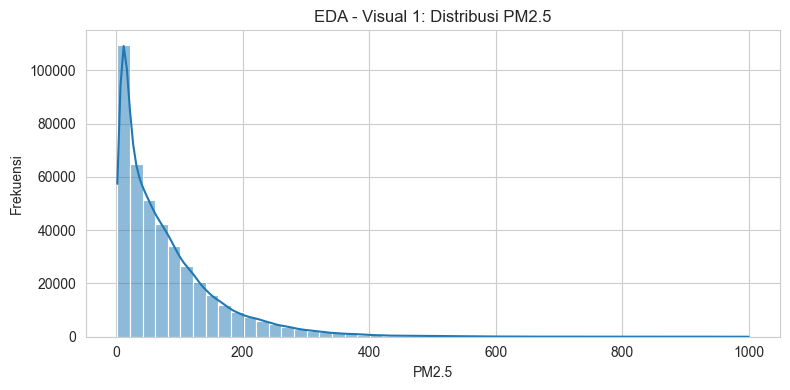

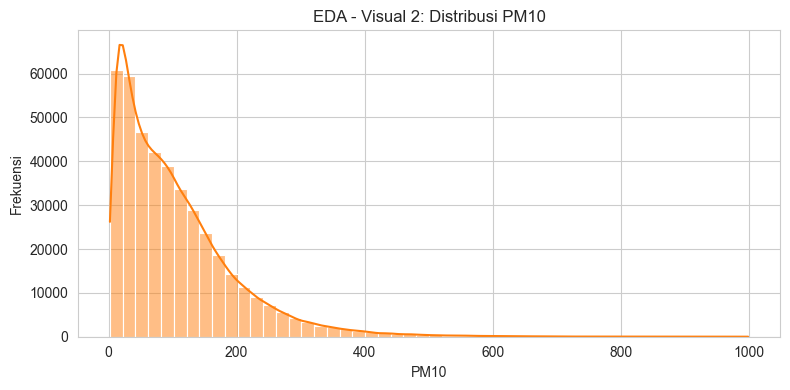

In [137]:
plt.figure(figsize=(8, 4))
sns.histplot(clean_df["PM2.5"], bins=50, kde=True, color="#1f77b4")
plt.title("EDA - Visual 1: Distribusi PM2.5")
plt.xlabel("PM2.5")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(clean_df["PM10"], bins=50, kde=True, color="#ff7f0e")
plt.title("EDA - Visual 2: Distribusi PM10")
plt.xlabel("PM10")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

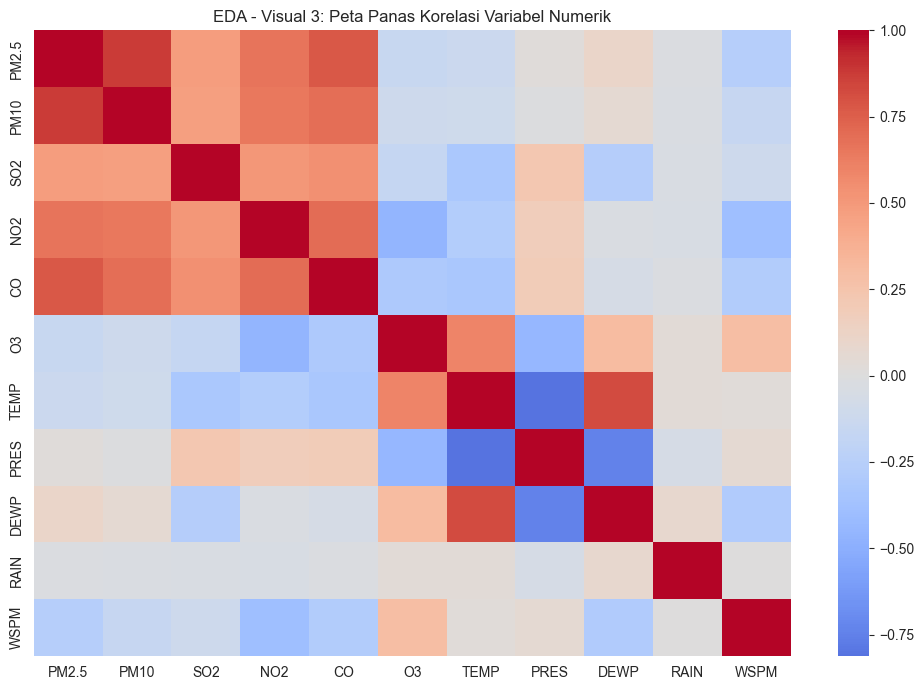

In [138]:
plt.figure(figsize=(10, 7))
sns.heatmap(correlation, cmap="coolwarm", center=0)
plt.title("EDA - Visual 3: Peta Panas Korelasi Variabel Numerik")
plt.tight_layout()
plt.show()

Insight:
- Sebaran PM2.5 dan PM10 didominasi nilai rendah hingga sedang, tapi ada lonjakan tinggi dan beberapa data ekstrem. Pola keduanya mirip, kemungkinan besar sumbernya sama.
- PM berkorelasi dengan CO dan NO2, menunjukkan pengaruh pembakaran dan kendaraan.
- O3 berkebalikan dengan polutan primer, tapi sejalan dengan suhu—ciri khas polusi fotokimia.
- Angin cukup efektif membersihkan partikel, tapi bisa meningkatkan O3 karena terbawa dari daerah lain.
- Hujan tidak banyak pengaruh terhadap naik turunnya polusi.
- Suhu, tekanan, dan titik embun saling terkait erat karena memang satu kesatuan sistem cuaca.


### Pertanyaan Bisnis 1: Area mana yang memerlukan intervensi prioritas berdasarkan tingkat polusi PM2.5 dan gas polutan, serta bagaimana tren perbaikannya dari waktu ke waktu?


In [139]:
priority_station = station_avg_pm25[["station", "zone", "PM2.5"]].head(5)
threshold_table = pd.DataFrame({
    "threshold": [35, 75, 150],
    "pct_hours": [
        (clean_df["PM2.5"] > 35).mean() * 100,
        (clean_df["PM2.5"] > 75).mean() * 100,
        (clean_df["PM2.5"] > 150).mean() * 100,
    ],
}).round(2)

display(yearly_avg)
display(priority_station)
display(threshold_table)

,year,PM2.5,PM10
0,2013,79.768553,103.199397
1,2014,86.183671,116.821115
2,2015,79.306423,103.655023
3,2016,72.078419,94.751717
4,2017,92.407898,110.880797


,station,zone,PM2.5
3,Dongsi,Perkotaan,86.144243
7,Nongzhanguan,Perkotaan,85.079472
11,Wanshouxigong,Perkotaan,85.067548
5,Gucheng,Pinggiran,84.074802
10,Wanliu,Perkotaan,83.467612


,threshold,pct_hours
0,35,62.70
1,75,39.07
2,150,15.18


In [140]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=yearly_avg["year"], y=yearly_avg["PM2.5"], mode="lines+markers", name="PM2.5"))
fig.add_trace(go.Scatter(x=yearly_avg["year"], y=yearly_avg["PM10"], mode="lines+markers", name="PM10"))
fig.update_layout(title="Q1 - Visual 1: Tren Tahunan PM2.5 dan PM10", xaxis_title="Tahun", yaxis_title="Konsentrasi", template="plotly_white")
fig.show()

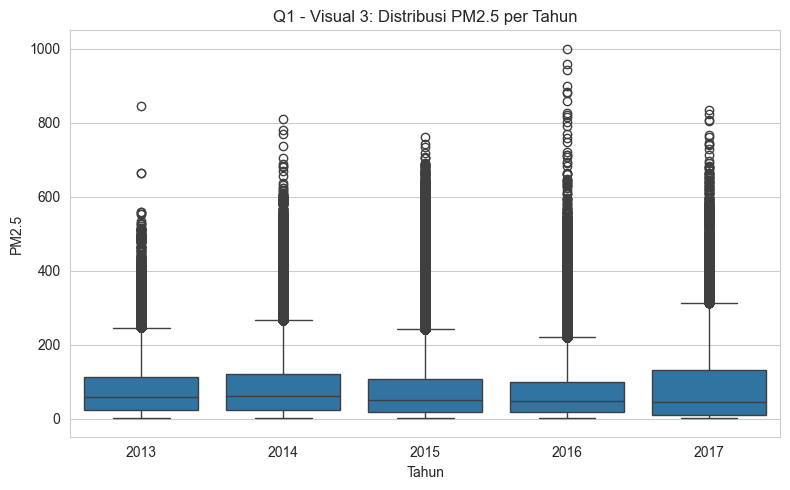

In [141]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=clean_df, x="year", y="PM2.5")
plt.title("Q1 - Visual 3: Distribusi PM2.5 per Tahun")
plt.xlabel("Tahun")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

### Subbagian Q1 - Perbandingan Zona (Geospasial tanpa ML)

In [142]:

# Peta sederhana menggunakan folium
zone_colors = {'Perkotaan': '#e74c3c', 'Pinggiran': '#f1c40f', 'Perdesaan': '#2ecc71'}

# Skala radius berbasis kuantil PM2.5 agar outlier tidak mendominasi
q1, q2, q3 = station_summary['PM2.5'].quantile([0.25, 0.50, 0.75])

def pm_radius_quantile(val):
    if pd.isna(val):
        return 6
    if val <= q1:
        return 6
    if val <= q2:
        return 8
    if val <= q3:
        return 10
    return 12

m = folium.Map(
    location=[station_coords['lat'].mean(), station_coords['lon'].mean()],
    zoom_start=9,
    tiles='OpenStreetMap'
)
folium.TileLayer('CartoDB positron', name='CartoDB Positron').add_to(m)

# Label berdasarkan skor gabungan (PM2.5 24h + episode rate) per zona
score_df = clean_df.sort_values(['station', 'datetime']).copy()
score_df['pm25_24h'] = score_df.groupby('station')['PM2.5'].transform(
    lambda s: s.rolling(24, min_periods=24).mean()
)
score_df['episode'] = score_df['pm25_24h'] >= 125.5

station_score = (
    score_df.groupby(['station','zone'])
    .agg(pm25_mean=('pm25_24h','mean'), episode_rate=('episode','mean'))
    .reset_index()
)

station_score['pm25_z'] = (station_score['pm25_mean'] - station_score['pm25_mean'].mean()) / station_score['pm25_mean'].std()
station_score['episode_z'] = (station_score['episode_rate'] - station_score['episode_rate'].mean()) / station_score['episode_rate'].std()
station_score['score'] = station_score['pm25_z'] + station_score['episode_z']

label_stations = set(
    station_score.sort_values(['zone','score'], ascending=[True, False])
    .groupby('zone').head(3)['station']
    .tolist()
)

label_layer = folium.FeatureGroup(name='Labels', show=False)

for _, r in station_summary.iterrows():
    if pd.isna(r['lat']) or pd.isna(r['lon']):
        continue
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=pm_radius_quantile(r['PM2.5']),
        color=zone_colors.get(r['zone'], '#555'),
        fill=True,
        fill_opacity=0.8,
        tooltip=(
            f"{r['station']}<br>"
            f"Zone: {r['zone']}<br>"
            f"PM2.5 mean: {r['PM2.5']:.1f}"
        )
    ).add_to(m)

    if r['station'] in label_stations:
        label_html = f'<div style="font-size:10px; color:#222; font-weight:bold;">{r["station"]}</div>'
        folium.Marker(
            location=[r['lat'], r['lon']],
            icon=folium.DivIcon(html=label_html)
        ).add_to(label_layer)

label_layer.add_to(m)

legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; z-index: 9999;
     background: white; padding: 10px 12px; border: 1px solid #999;
     border-radius: 4px; font-size: 12px;">
<strong>Zona</strong><br>
<span style="display:inline-block; width:10px; height:10px; background:#e74c3c; margin-right:6px;"></span>Perkotaan<br>
<span style="display:inline-block; width:10px; height:10px; background:#f1c40f; margin-right:6px;"></span>Pinggiran<br>
<span style="display:inline-block; width:10px; height:10px; background:#2ecc71; margin-right:6px;"></span>Perdesaan
</div>
'''

size_legend = f'''
<div style="position: fixed; bottom: 30px; right: 30px; z-index: 9999;
     background: white; padding: 10px 12px; border: 1px solid #999;
     border-radius: 4px; font-size: 12px;">
<strong>Skala PM2.5 (kuantil)</strong><br>
<span style="display:inline-block; width:12px; height:12px; border: 2px solid #333; border-radius: 50%;"></span>
<span style="margin-left:6px;">≤ {q1:.1f}</span><br>
<span style="display:inline-block; width:16px; height:16px; border: 2px solid #333; border-radius: 50%;"></span>
<span style="margin-left:6px;">≤ {q2:.1f}</span><br>
<span style="display:inline-block; width:20px; height:20px; border: 2px solid #333; border-radius: 50%;"></span>
<span style="margin-left:6px;">≤ {q3:.1f}</span><br>
<span style="display:inline-block; width:24px; height:24px; border: 2px solid #333; border-radius: 50%;"></span>
<span style="margin-left:6px;">> {q3:.1f}</span>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))
m.get_root().html.add_child(folium.Element(size_legend))
folium.LayerControl(collapsed=True).add_to(m)

zoom_threshold = 12
map_id = m.get_name()
label_id = label_layer.get_name()
script = """
<script>
(function() {{
  var map = {map_id};
  var labels = {label_id};
  function toggleLabels() {{
    if (map.getZoom() >= {zoom_threshold}) {{
      if (!map.hasLayer(labels)) {{ map.addLayer(labels); }}
    }} else {{
      if (map.hasLayer(labels)) {{ map.removeLayer(labels); }}
    }}
  }}
  map.on("zoomend", toggleLabels);
  toggleLabels();
}})();
</script>
""".format(map_id=map_id, label_id=label_id, zoom_threshold=zoom_threshold)

m.get_root().html.add_child(folium.Element(script))

m

Catatan Asumsi dan Keterbatasan Analisis Geospasial:
- Koordinat stasiun berasal dari Google Maps sebagai proksi visual.
- Analisis dipakai untuk membandingkan pola relatif antar area, bukan pengukuran jarak presisi atau inferensi kausal spasial ketat.

In [143]:
station_summary = station_avg_pm25.merge(
    station_coords[["station", "lat", "lon"]],
    on="station",
    how="left"
).sort_values("PM2.5", ascending=False)

display(station_summary)
display(zone_avg_pm25)

,station,zone,PM2.5,lat,lon
0,Dongsi,Perkotaan,86.144243,39.929,116.417
1,Nongzhanguan,Perkotaan,85.079472,39.937,116.461
2,Wanshouxigong,Perkotaan,85.067548,39.878,116.352
3,Gucheng,Pinggiran,84.074802,39.914,116.184
4,Wanliu,Perkotaan,83.467612,39.987,116.287
5,Guanyuan,Perkotaan,82.897522,39.929,116.339
6,Aotizhongxin,Perkotaan,82.540623,39.982,116.397
7,Tiantan,Perkotaan,82.033097,39.886,116.407
8,Shunyi,Pinggiran,79.437962,40.127,116.655
9,Changping,Pinggiran,70.986438,40.217,116.230


,zone,PM2.5
1,Perkotaan,83.890017
2,Pinggiran,78.166400
0,Perdesaan,68.173652


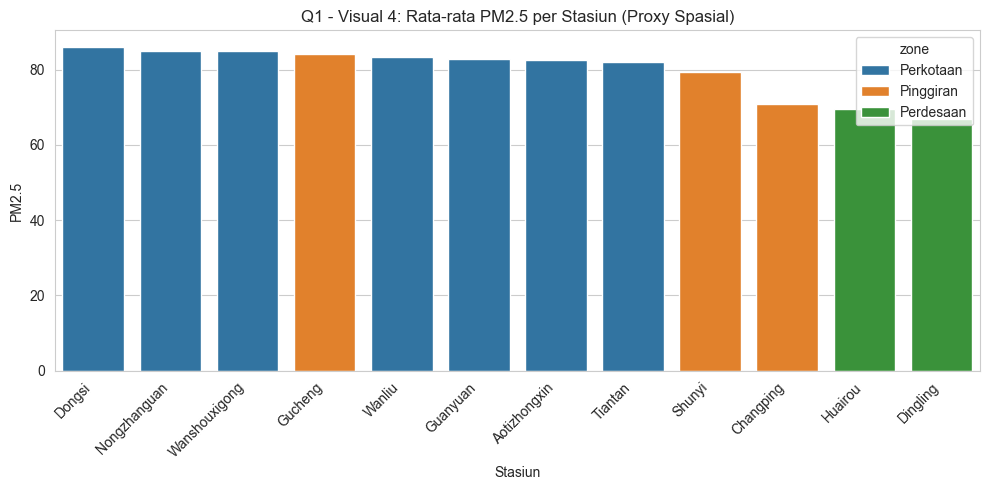

In [144]:
plt.figure(figsize=(10, 5))
sns.barplot(data=station_avg_pm25, x="station", y="PM2.5", hue="zone")
plt.title("Q1 - Visual 4: Rata-rata PM2.5 per Stasiun (Proxy Spasial)")
plt.xlabel("Stasiun")
plt.ylabel("PM2.5")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

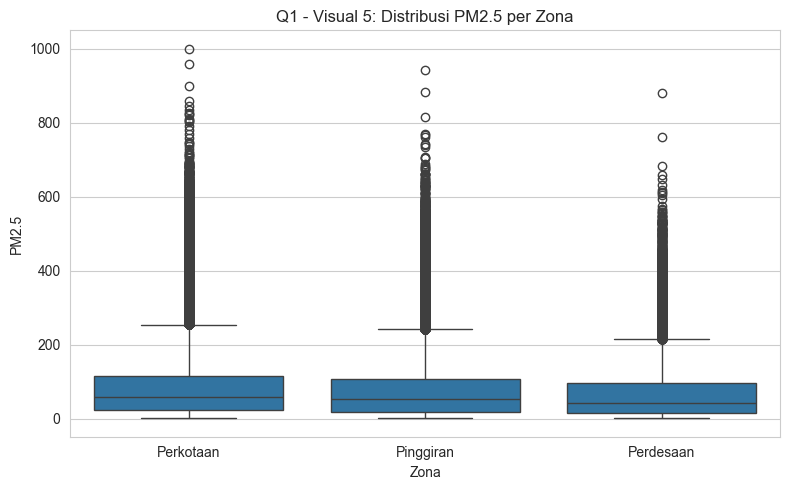

In [145]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=clean_df, x="zone", y="PM2.5", order=["Perkotaan", "Pinggiran", "Perdesaan"])
plt.title("Q1 - Visual 5: Distribusi PM2.5 per Zona")
plt.xlabel("Zona")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

In [146]:
pollutant_means = clean_df.groupby("station")[["PM2.5", "PM10", "NO2", "CO", "SO2", "O3"]].mean().round(2)
variation_check = pollutant_means.nunique().to_frame("n_unique")

display(pollutant_means)
display(variation_check)

,PM2.5,PM10,NO2,CO,SO2,O3
station,,,,,,
Aotizhongxin,82.54,110.21,59.07,1264.69,17.46,55.33
Changping,70.99,94.79,44.21,1156.99,14.94,57.98
Dingling,66.85,84.11,27.30,925.11,11.80,70.53
Dongsi,86.14,110.35,53.95,1331.91,18.51,57.70
Guanyuan,82.90,109.37,58.14,1258.33,17.61,54.82
Gucheng,84.07,119.26,55.82,1338.10,15.71,58.00
Huairou,69.50,92.42,32.08,1019.67,12.45,60.87
Nongzhanguan,85.08,109.38,58.10,1327.77,18.76,58.43
Shunyi,79.44,99.27,44.09,1197.90,13.45,54.22


,n_unique
PM2.5,12
PM10,12
NO2,12
CO,12
SO2,12
O3,12


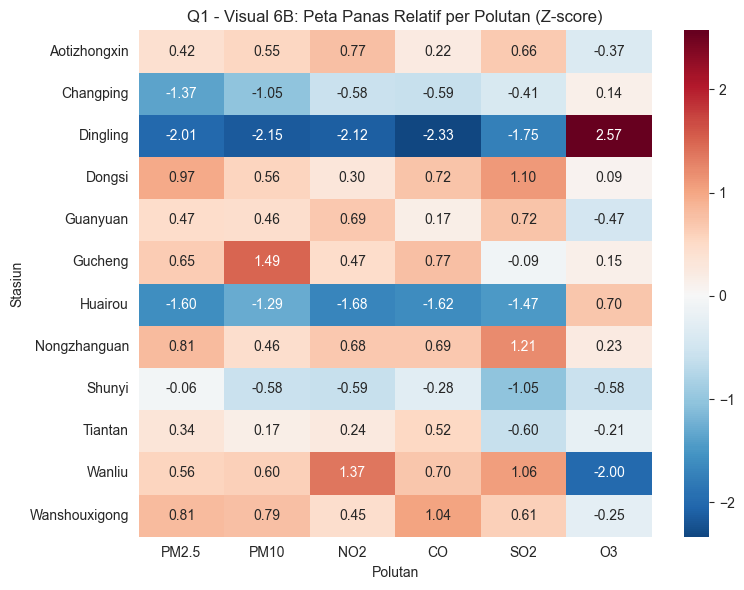

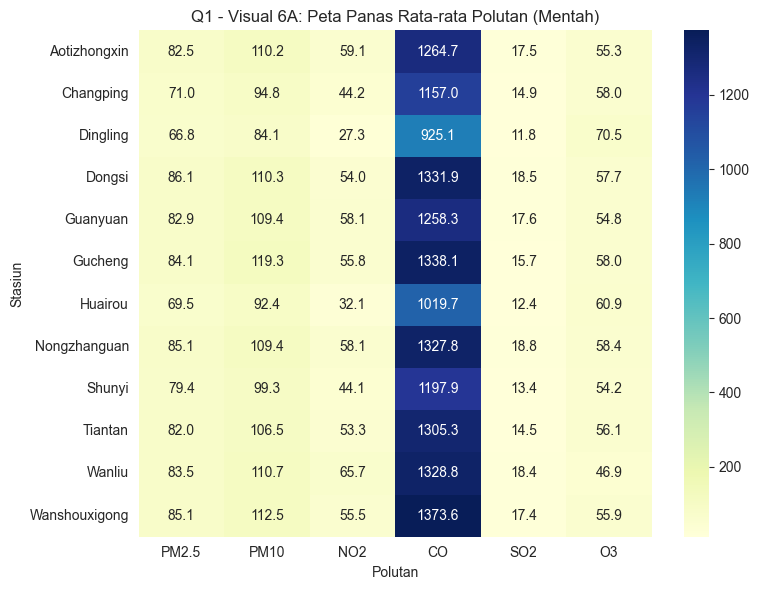

In [147]:
pollutant_z = pollutant_means.apply(
    lambda col: (col - col.mean()) / col.std(ddof=0) if col.std(ddof=0) != 0 else 0,
    axis=0,
)

plt.figure(figsize=(8, 6))
sns.heatmap(pollutant_z, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Q1 - Visual 6B: Peta Panas Relatif per Polutan (Z-score)")
plt.xlabel("Polutan")
plt.ylabel("Stasiun")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pollutant_means, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Q1 - Visual 6A: Peta Panas Rata-rata Polutan (Mentah)")
plt.xlabel("Polutan")
plt.ylabel("Stasiun")
plt.tight_layout()
plt.show()

### Subbagian Q1 - Clustering Manual Stasiun Berbasis Gas Polutan

Clustering ini memakai aturan bisnis berbasis kuantil pada skor gabungan rata-rata NO2, SO2, CO, O3 per stasiun (setelah standardisasi), sehingga stasiun terbagi ke kelas Low, Medium, High.


/var/folders/rg/227_g6ws7ys64whyfwgmc5sc0000gn/T/ipykernel_5662/789716841.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



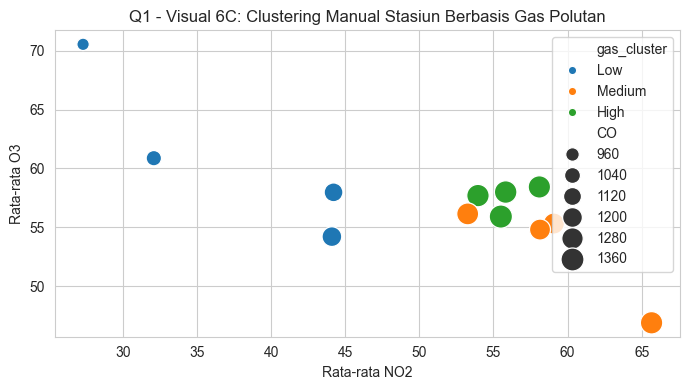

,gas_cluster,n_station
0,Low,4
1,Medium,4
2,High,4


,gas_cluster,NO2,SO2,CO,O3,gas_score
0,Low,36.92,13.16,1074.92,60.90,-0.73
1,Medium,59.04,17.00,1289.28,53.30,0.22
2,High,55.84,17.58,1342.85,57.51,0.51


,station,NO2,SO2,CO,O3,z_NO2,z_SO2,z_CO,z_O3,gas_score,gas_cluster
7,Nongzhanguan,58.095,18.760,1327.768,58.433,0.682,1.210,0.691,0.231,0.704,High
3,Dongsi,53.953,18.506,1331.913,57.700,0.305,1.102,0.723,0.089,0.555,High
11,Wanshouxigong,55.495,17.363,1373.619,55.920,0.445,0.616,1.036,-0.255,0.461,High
5,Gucheng,55.822,15.706,1338.100,58.000,0.475,-0.088,0.769,0.147,0.326,High
0,Aotizhongxin,59.074,17.459,1264.692,55.329,0.771,0.657,0.218,-0.369,0.319,Medium
10,Wanliu,65.668,18.410,1328.761,46.909,1.371,1.061,0.699,-1.997,0.283,Medium
4,Guanyuan,58.139,17.609,1258.327,54.817,0.686,0.721,0.170,-0.468,0.277,Medium
9,Tiantan,53.259,14.510,1305.333,56.148,0.242,-0.596,0.523,-0.211,-0.011,Medium
1,Changping,44.206,14.943,1156.990,57.976,-0.581,-0.412,-0.591,0.143,-0.360,Low
8,Shunyi,44.095,13.446,1197.905,54.219,-0.592,-1.049,-0.284,-0.584,-0.627,Low


In [148]:
# Q1 - Visual 6C: Manual Clustering Stasiun Berbasis Gas Polutan (NO2, SO2, CO, O3)
station_gas_profile = (
    clean_df.groupby('station')[['NO2', 'SO2', 'CO', 'O3']]
    .mean()
    .reset_index()
)

# Standardisasi agar setiap gas punya bobot seimbang dalam skor gabungan
for col in ['NO2', 'SO2', 'CO', 'O3']:
    mu = station_gas_profile[col].mean()
    sd = station_gas_profile[col].std(ddof=0)
    station_gas_profile[f'z_{col}'] = (station_gas_profile[col] - mu) / sd if sd != 0 else 0

station_gas_profile['gas_score'] = station_gas_profile[['z_NO2', 'z_SO2', 'z_CO', 'z_O3']].mean(axis=1)
q33, q66 = station_gas_profile['gas_score'].quantile([0.33, 0.66])

station_gas_profile['gas_cluster'] = pd.cut(
    station_gas_profile['gas_score'],
    bins=[-np.inf, q33, q66, np.inf],
    labels=['Low', 'Medium', 'High']
)

cluster_count = station_gas_profile['gas_cluster'].value_counts().rename_axis('gas_cluster').reset_index(name='n_station')
cluster_summary = (
    station_gas_profile.groupby('gas_cluster')[['NO2', 'SO2', 'CO', 'O3', 'gas_score']]
    .mean()
    .round(2)
    .reset_index()
)

plt.figure(figsize=(7,4))
sns.scatterplot(
    data=station_gas_profile,
    x='NO2',
    y='O3',
    hue='gas_cluster',
    size='CO',
    sizes=(80, 280)
)
plt.title('Q1 - Visual 6C: Clustering Manual Stasiun Berbasis Gas Polutan')
plt.xlabel('Rata-rata NO2')
plt.ylabel('Rata-rata O3')
plt.tight_layout()
plt.show()

display(cluster_count)
display(cluster_summary)
display(station_gas_profile.sort_values('gas_score', ascending=False).round(3))


Insight (jawaban Q1):
- Rata-rata tahunan PM2.5 menurun dari 2014 ke 2016, lalu naik kembali pada 2017 (data parsial Jan–Feb), menunjukkan perbaikan sementara namun belum konsisten.
- Stasiun dengan PM2.5 tertinggi adalah Dongsi, diikuti Nongzhanguan dan Wanshouxigong.
- Perbedaan zona konsisten terlihat: Perkotaan cenderung memiliki PM2.5 lebih tinggi dibanding Pinggiran dan Perdesaan, sehingga prioritas intervensi spasial tetap difokuskan ke zona perkotaan.
- Sekitar 39% jam melebihi batas 75, menandakan risiko polusi masih tinggi meski ada periode perbaikan.
- Clustering manual berbasis gas polutan menghasilkan distribusi seimbang: High = 4 stasiun, Medium = 4 stasiun, Low = 4 stasiun.
- Kelompok High didominasi stasiun Nongzhanguan, Dongsi, Wanshouxigong, dan Gucheng dengan skor gabungan gas tertinggi, sehingga layak diprioritaskan untuk pengendalian emisi gas.


### Pertanyaan Bisnis 2: Kapan waktu-waktu kritis yang perlu menjadi fokus pengawasan emisi dan perlindungan kesehatan masyarakat?


In [149]:
monthly_pol = clean_df.groupby("month_year")[["NO2", "CO", "SO2", "O3"]].mean().reset_index()
monthly_pol["month_year"] = pd.to_datetime(monthly_pol["month_year"])

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    subplot_titles=("NO2, SO2, O3", "CO")
)
for col in ["NO2", "SO2", "O3"]:
    fig.add_trace(go.Scatter(x=monthly_pol["month_year"], y=monthly_pol[col], mode="lines", name=col), row=1, col=1)
fig.add_trace(go.Scatter(x=monthly_pol["month_year"], y=monthly_pol["CO"], mode="lines", name="CO", line=dict(color="#d62728")), row=2, col=1)

fig.update_layout(title="Q2 - Visual 1: Tren Bulanan Polutan (CO dipisah sumbu)", template="plotly_white", height=700)
fig.update_xaxes(title_text="Bulan", row=2, col=1)
fig.update_yaxes(title_text="Konsentrasi", row=1, col=1)
fig.update_yaxes(title_text="Konsentrasi CO", row=2, col=1)
fig.show()

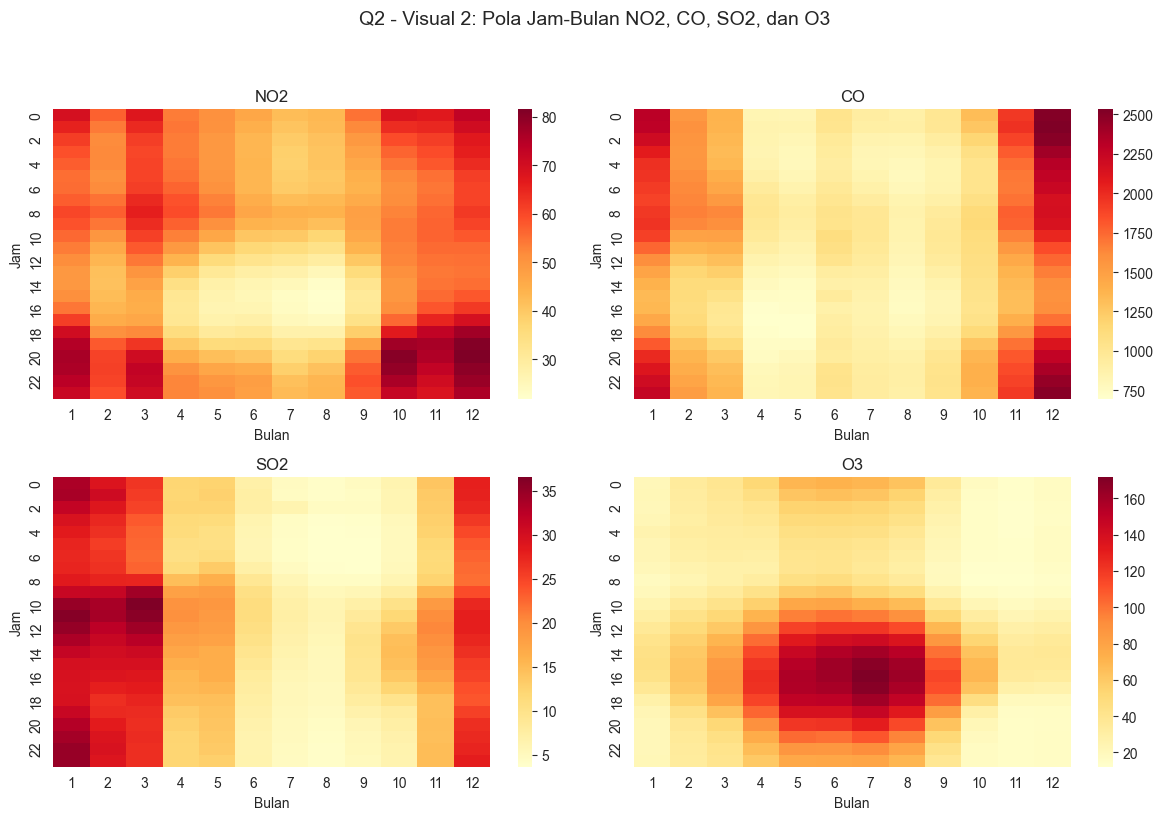

In [150]:
# Q2 - Visual 2: Heatmap jam vs bulan untuk NO2, CO, SO2, O3
pollutants = ["NO2", "CO", "SO2", "O3"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, pol in zip(axes, pollutants):
    pivot = clean_df.pivot_table(index="hour", columns="month", values=pol, aggfunc="mean")
    sns.heatmap(pivot, cmap="YlOrRd", ax=ax)
    ax.set_title(pol)
    ax.set_xlabel("Bulan")
    ax.set_ylabel("Jam")

fig.suptitle("Q2 - Visual 2: Pola Jam-Bulan NO2, CO, SO2, dan O3", y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [151]:
month_peak = (
    clean_df.groupby("month")[["NO2", "CO", "SO2", "O3"]]
    .mean().idxmax().rename("peak_month").reset_index().rename(columns={"index": "pollutant"})
)
hour_peak = (
    clean_df.groupby("hour")[["NO2", "CO", "SO2", "O3"]]
    .mean().idxmax().rename("peak_hour").reset_index().rename(columns={"index": "pollutant"})
)
peak_table = month_peak.merge(hour_peak, on="pollutant", how="inner")
display(peak_table)

,pollutant,peak_month,peak_hour
0,NO2,12,22
1,CO,12,1
2,SO2,1,11
3,O3,7,16


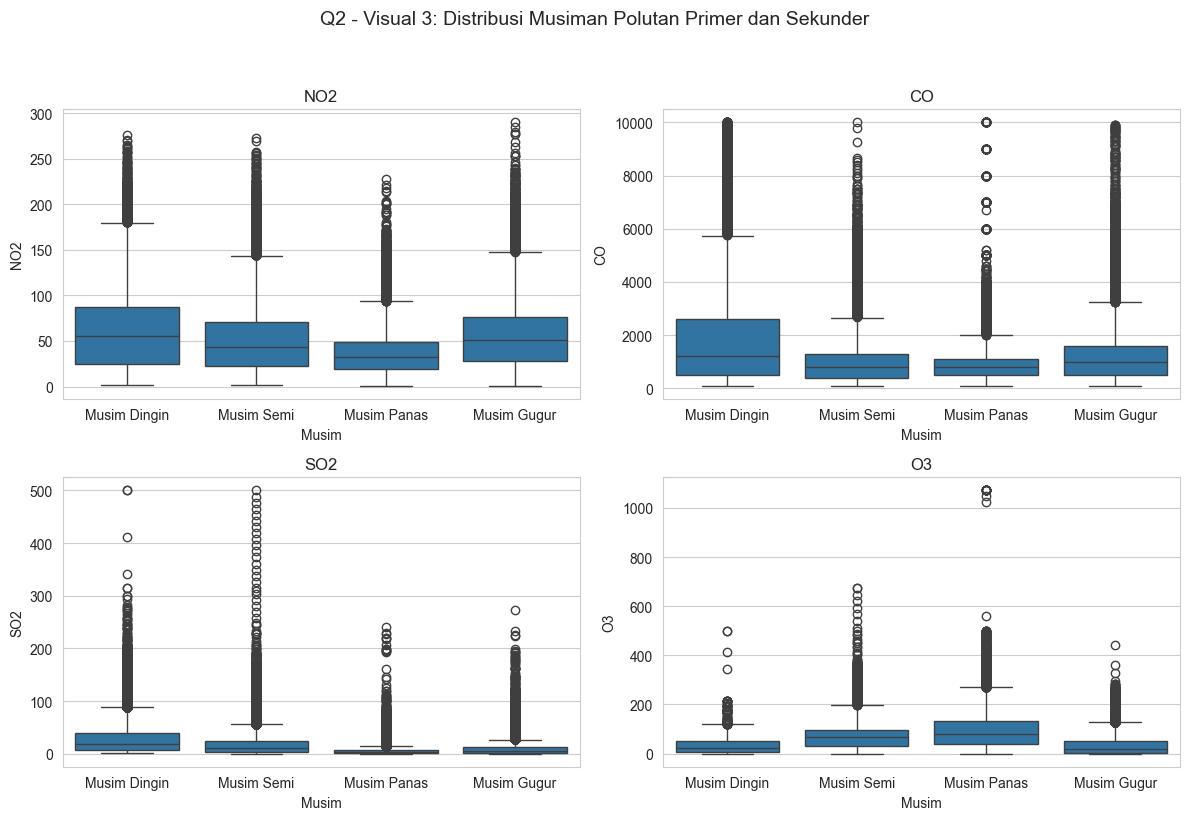

In [152]:
# Q2 - Visual 3: Distribusi musiman polutan primer/sekunder (NO2, CO, SO2, O3)
season_order = ["Musim Dingin", "Musim Semi", "Musim Panas", "Musim Gugur"]
pols = ["NO2", "CO", "SO2", "O3"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, pol in zip(axes, pols):
    sns.boxplot(data=clean_df, x="season", y=pol, order=season_order, ax=ax)
    ax.set_title(pol)
    ax.set_xlabel("Musim")
    ax.set_ylabel(pol)

fig.suptitle("Q2 - Visual 3: Distribusi Musiman Polutan Primer dan Sekunder", y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Insight (jawaban Q2):
- Polutan primer (NO2, CO, SO2) tertinggi pada Musim Dingin–Musim Gugur, terutama malam hingga dini hari.
- O3 mencapai puncak pada Musim Panas, terutama siang hingga sore saat radiasi matahari kuat.
- Episode ekstrem primer paling sering muncul di musim dingin, menunjukkan periode risiko tinggi.
- Pola berlawanan antara O3 dan polutan primer menegaskan perbedaan proses: akumulasi emisi vs fotokimia.
- Musim dan jam bersama-sama menentukan waktu kritis untuk pemantauan dan mitigasi kualitas udara.

### Pertanyaan Analisis Lanjutan 1 (tanpa ML): Faktor meteorologi apa yang paling berkontribusi terhadap peningkatan risiko polusi, sehingga bisa dijadikan indikator peringatan dini?

Bagian ini fokus pada asosiasi (korelasi Spearman), bukan inferensi kausal. Variabel `wd` dianalisis sebagai perbandingan rerata polutan per arah angin.


In [153]:
# Q3 - Persiapan data asosiasi musiman/temporal
assoc_df = clean_df.copy()

if 'season' not in assoc_df.columns:
    season_map = {
        12: 'WINTER', 1: 'WINTER', 2: 'WINTER',
        3: 'SPRING', 4: 'SPRING', 5: 'SPRING',
        6: 'SUMMER', 7: 'SUMMER', 8: 'SUMMER',
        9: 'AUTUMN', 10: 'AUTUMN', 11: 'AUTUMN'
    }
    assoc_df['season_en'] = assoc_df['month'].map(season_map)
else:
    season_norm = {
        'Musim Dingin': 'WINTER', 'Musim Semi': 'SPRING',
        'Musim Panas': 'SUMMER', 'Musim Gugur': 'AUTUMN',
        'WINTER': 'WINTER', 'SPRING': 'SPRING', 'SUMMER': 'SUMMER', 'AUTUMN': 'AUTUMN'
    }
    assoc_df['season_en'] = assoc_df['season'].map(season_norm).fillna(assoc_df['season'])

season_order = ['SPRING', 'SUMMER', 'AUTUMN', 'WINTER']
pm_cols = ['PM2.5', 'PM10']
gas_cols = ['CO', 'NO2', 'SO2', 'O3']
met_cols = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

for c in pm_cols + gas_cols + met_cols:
    assoc_df[c] = pd.to_numeric(assoc_df[c], errors='coerce')

def corr_by_group(data, group_col, left_cols, right_cols, method='spearman'):
    rows = []
    groups = season_order if group_col == 'season_en' else sorted(data[group_col].dropna().unique())
    for g in groups:
        sub = data[data[group_col] == g]
        if sub.empty:
            continue
        corr = sub[left_cols + right_cols].corr(method=method)
        for l in left_cols:
            for r in right_cols:
                rows.append({'group': g, 'left': l, 'right': r, 'rho': corr.loc[l, r]})
    return pd.DataFrame(rows)

season_pm_met = corr_by_group(assoc_df, 'season_en', pm_cols, met_cols)
season_gas_met = corr_by_group(assoc_df, 'season_en', gas_cols, met_cols)

display(season_pm_met.head())
display(season_gas_met.head())


,group,left,right,rho
0,SPRING,PM2.5,TEMP,0.027954
1,SPRING,PM2.5,PRES,-0.150915
2,SPRING,PM2.5,DEWP,0.445742
3,SPRING,PM2.5,RAIN,-0.007157
4,SPRING,PM2.5,WSPM,-0.285875


,group,left,right,rho
0,SPRING,CO,TEMP,-0.167082
1,SPRING,CO,PRES,-0.002167
2,SPRING,CO,DEWP,0.321530
3,SPRING,CO,RAIN,0.027115
4,SPRING,CO,WSPM,-0.374869


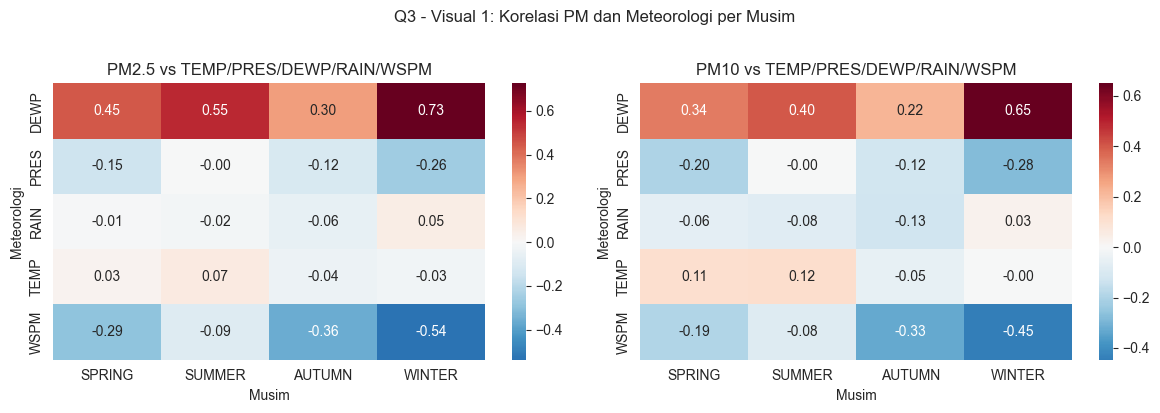

In [154]:
# Q3 - Visual 1: Korelasi PM dengan faktor meteorologi per musim (Spearman)
pm25_met = (
    season_pm_met[season_pm_met['left'] == 'PM2.5']
    .pivot(index='right', columns='group', values='rho')
    .reindex(columns=season_order)
)
pm10_met = (
    season_pm_met[season_pm_met['left'] == 'PM10']
    .pivot(index='right', columns='group', values='rho')
    .reindex(columns=season_order)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(pm25_met, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[0])
axes[0].set_title('PM2.5 vs TEMP/PRES/DEWP/RAIN/WSPM')
axes[0].set_xlabel('Musim')
axes[0].set_ylabel('Meteorologi')

sns.heatmap(pm10_met, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1])
axes[1].set_title('PM10 vs TEMP/PRES/DEWP/RAIN/WSPM')
axes[1].set_xlabel('Musim')
axes[1].set_ylabel('Meteorologi')

fig.suptitle('Q3 - Visual 1: Korelasi PM dan Meteorologi per Musim', y=1.02)
plt.tight_layout()
plt.show()


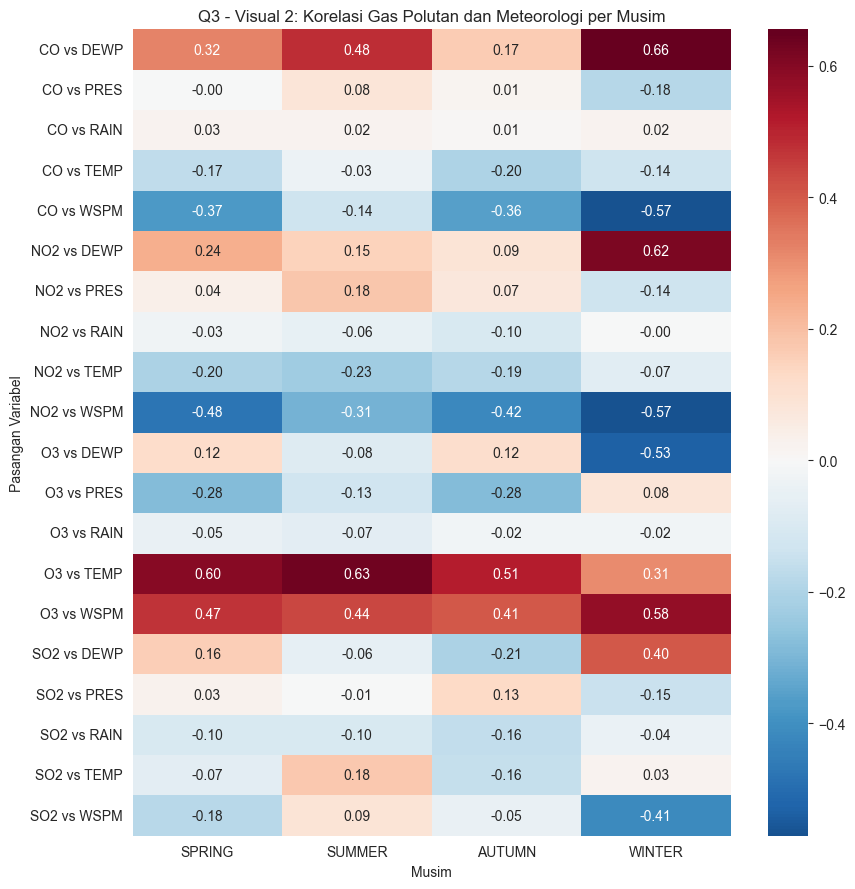

In [155]:
# Q3 - Visual 2: Korelasi gas polutan dengan faktor meteorologi per musim (Spearman)
plot_gas_met = season_gas_met.copy()
plot_gas_met['pair'] = plot_gas_met['left'] + ' vs ' + plot_gas_met['right']

pivot_gas_met = plot_gas_met.pivot(index='pair', columns='group', values='rho').reindex(columns=season_order)

plt.figure(figsize=(9, 9))
sns.heatmap(pivot_gas_met, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Q3 - Visual 2: Korelasi Gas Polutan dan Meteorologi per Musim')
plt.xlabel('Musim')
plt.ylabel('Pasangan Variabel')
plt.tight_layout()
plt.show()


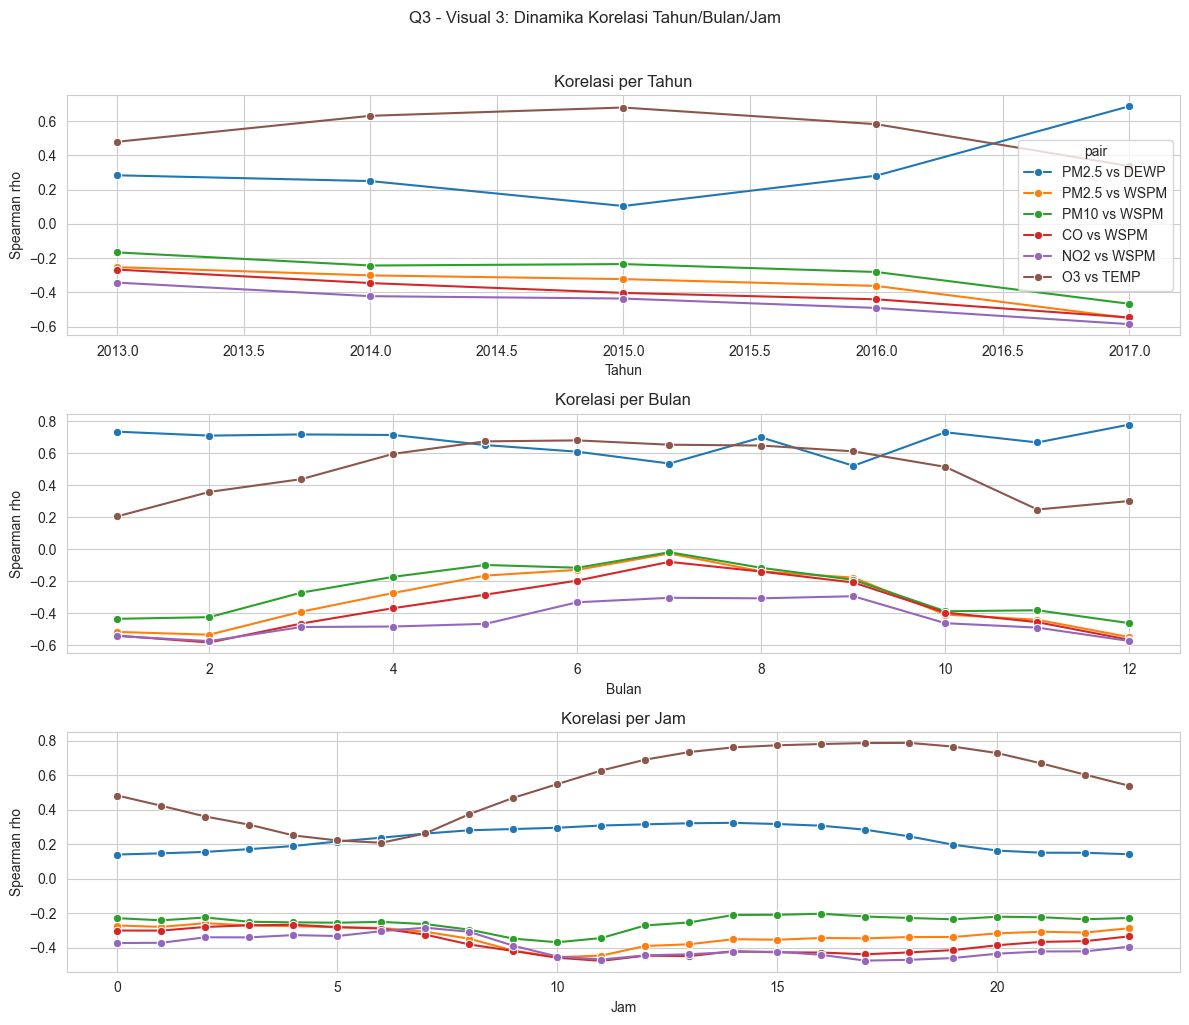

,grain,group,pair,rho
0,year,2013,PM2.5 vs DEWP,0.284021
1,year,2013,PM2.5 vs WSPM,-0.252262
2,year,2013,PM10 vs WSPM,-0.166110
3,year,2013,CO vs WSPM,-0.266533
4,year,2013,NO2 vs WSPM,-0.342477


,grain,group,pair,rho
0,month,1,PM2.5 vs DEWP,0.735110
1,month,1,PM2.5 vs WSPM,-0.516938
2,month,1,PM10 vs WSPM,-0.434874
3,month,1,CO vs WSPM,-0.540320
4,month,1,NO2 vs WSPM,-0.542457


,grain,group,pair,rho
0,hour,0,PM2.5 vs DEWP,0.139539
1,hour,0,PM2.5 vs WSPM,-0.271849
2,hour,0,PM10 vs WSPM,-0.229124
3,hour,0,CO vs WSPM,-0.300993
4,hour,0,NO2 vs WSPM,-0.373760


In [156]:
# Q3 - Visual 3: Dinamika korelasi pada skala tahun, bulan, dan jam
key_pairs = [('PM2.5', 'DEWP'), ('PM2.5', 'WSPM'), ('PM10', 'WSPM'), ('CO', 'WSPM'), ('NO2', 'WSPM'), ('O3', 'TEMP')]

def key_corr_by_grain(data, grain_col, pairs, min_n=30):
    rows = []
    for g, sub in data.groupby(grain_col):
        for a, b in pairs:
            valid = sub[[a, b]].dropna()
            rho = valid[a].corr(valid[b], method='spearman') if len(valid) >= min_n else np.nan
            rows.append({'grain': grain_col, 'group': g, 'pair': f'{a} vs {b}', 'rho': rho})
    return pd.DataFrame(rows)

year_corr = key_corr_by_grain(assoc_df, 'year', key_pairs)
month_corr = key_corr_by_grain(assoc_df, 'month', key_pairs)
hour_corr = key_corr_by_grain(assoc_df, 'hour', key_pairs)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

sns.lineplot(data=year_corr, x='group', y='rho', hue='pair', marker='o', ax=axes[0])
axes[0].set_title('Korelasi per Tahun')
axes[0].set_xlabel('Tahun')
axes[0].set_ylabel('Spearman rho')

sns.lineplot(data=month_corr, x='group', y='rho', hue='pair', marker='o', ax=axes[1], legend=False)
axes[1].set_title('Korelasi per Bulan')
axes[1].set_xlabel('Bulan')
axes[1].set_ylabel('Spearman rho')

sns.lineplot(data=hour_corr, x='group', y='rho', hue='pair', marker='o', ax=axes[2], legend=False)
axes[2].set_title('Korelasi per Jam')
axes[2].set_xlabel('Jam')
axes[2].set_ylabel('Spearman rho')

fig.suptitle('Q3 - Visual 3: Dinamika Korelasi Tahun/Bulan/Jam', y=1.02)
plt.tight_layout()
plt.show()

display(year_corr.head())
display(month_corr.head())
display(hour_corr.head())


,season_en,wd,PM2.5,O3
2,AUTUMN,ESE,103.86,35.58
0,AUTUMN,E,102.49,29.03
1,AUTUMN,ENE,101.02,21.55
18,SPRING,ESE,97.51,68.66
16,SPRING,E,94.99,52.70
25,SPRING,SE,93.35,80.97
34,SUMMER,ESE,81.62,99.07
41,SUMMER,SE,81.15,119.08
42,SUMMER,SSE,79.49,139.18
48,WINTER,E,147.06,18.19


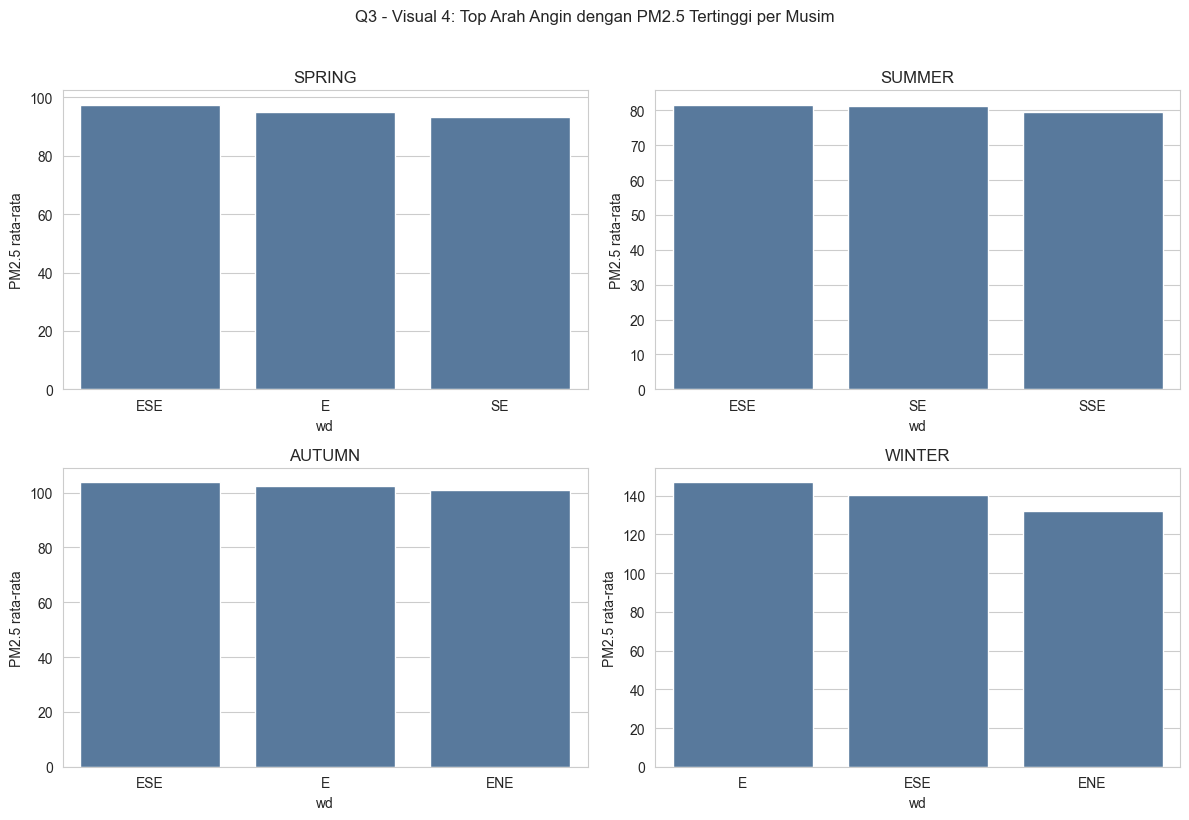

In [157]:
# Q3 - Visual 4: Arah angin (wd) dan rerata PM2.5 per musim
wd_summary = (
    assoc_df.groupby(['season_en', 'wd'])[['PM2.5', 'PM10', 'CO', 'NO2', 'SO2', 'O3']]
    .mean()
    .reset_index()
)

top_wd_pm25 = (
    wd_summary.sort_values(['season_en', 'PM2.5'], ascending=[True, False])
    .groupby('season_en')
    .head(3)
)

display(top_wd_pm25[['season_en', 'wd', 'PM2.5', 'O3']].round(2))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, s in enumerate(season_order):
    sub = top_wd_pm25[top_wd_pm25['season_en'] == s]
    sns.barplot(data=sub, x='wd', y='PM2.5', ax=axes[i], color='#4c78a8')
    axes[i].set_title(s)
    axes[i].set_xlabel('wd')
    axes[i].set_ylabel('PM2.5 rata-rata')

fig.suptitle('Q3 - Visual 4: Top Arah Angin dengan PM2.5 Tertinggi per Musim', y=1.02)
plt.tight_layout()
plt.show()


Insight (jawaban Q3):
- Untuk PM, faktor meteorologi yang paling konsisten berasosiasi adalah DEWP (positif) dan WSPM (negatif), terutama pada Winter (contoh PM2.5-DEWP sekitar 0.726 dan PM2.5-WSPM sekitar -0.537).
- Untuk gas polutan, O3-TEMP konsisten positif kuat (Spring sekitar 0.595, Summer sekitar 0.633), sedangkan NO2/CO-WSPM cenderung negatif, terutama pada Autumn-Winter.
- Variabel RAIN cenderung menunjukkan asosiasi lemah pada sebagian besar pasangan, sehingga bukan faktor dominan dalam pola jangka pendek pada data jam-jaman.
- Pada skala tahun/bulan/jam, pola inti meteorologi relatif stabil: pasangan berbasis WSPM umumnya negatif untuk PM/NO2/CO, sementara pasangan O3-TEMP tetap positif.
- Analisis arah angin menunjukkan sektor tertentu (sering timur-tenggara) berkaitan dengan rerata PM2.5 lebih tinggi, menandakan kemungkinan kontribusi sumber upwind musiman.


### Pertanyaan Analisis Lanjutan 2 - AQI Multi-Polutan (tanpa ML): Polutan apa yang menjadi penyebab utama penurunan kualitas udara, dan bagaimana prioritas pengendaliannya berdasarkan tingkat risikonya?

Sumber AQI (referensi resmi): US EPA AQS Breakpoints (tabel breakpoint AQI resmi, termasuk PM2.5, PM10, CO, NO2, SO2, O3): [https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html](https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)


In [158]:
base_df = clean_df.sort_values(["station", "datetime"]).copy()

labels6 = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"]
pm25_bins = [-np.inf, 9.0, 35.4, 55.4, 125.4, 225.4, np.inf]
pm10_bins = [-np.inf, 54.0, 154.0, 254.0, 354.0, 424.0, np.inf]
co_bins = [-np.inf, 4.4, 9.4, 12.4, 15.4, 30.4, np.inf]
no2_bins = [-np.inf, 53.0, 100.0, 360.0, 649.0, 1249.0, np.inf]
so2_bins = [-np.inf, 35.0, 75.0, 185.0, 304.0, 604.0, np.inf]
o3_8h_bins = [-np.inf, 0.054, 0.070, 0.085, 0.105, 0.200, np.inf]
o3_8h_labels = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Outside 8h AQI scope"]

def ugm3_to_ppm(ugm3, mw):
    return (ugm3 * 24.45) / (mw * 1000.0)

def ugm3_to_ppb(ugm3, mw):
    return (ugm3 * 24.45) / mw

base_df["pm25_24h"] = base_df.groupby("station")["PM2.5"].transform(lambda s: s.rolling(24, min_periods=24).mean())
base_df["pm10_24h"] = base_df.groupby("station")["PM10"].transform(lambda s: s.rolling(24, min_periods=24).mean())
base_df["co_8h_ugm3"] = base_df.groupby("station")["CO"].transform(lambda s: s.rolling(8, min_periods=8).mean())
base_df["o3_8h_ugm3"] = base_df.groupby("station")["O3"].transform(lambda s: s.rolling(8, min_periods=8).mean())

base_df["co_8h_ppm"] = ugm3_to_ppm(base_df["co_8h_ugm3"], 28.01)
base_df["o3_8h_ppm"] = ugm3_to_ppm(base_df["o3_8h_ugm3"], 48.0)
base_df["no2_1h_ppb"] = ugm3_to_ppb(base_df["NO2"], 46.01)
base_df["so2_1h_ppb"] = ugm3_to_ppb(base_df["SO2"], 64.07)

base_df["pm25_cat"] = pd.cut(base_df["pm25_24h"], bins=pm25_bins, labels=labels6)
base_df["pm10_cat"] = pd.cut(base_df["pm10_24h"], bins=pm10_bins, labels=labels6)
base_df["co_cat"] = pd.cut(base_df["co_8h_ppm"], bins=co_bins, labels=labels6)
base_df["no2_cat"] = pd.cut(base_df["no2_1h_ppb"], bins=no2_bins, labels=labels6)
base_df["so2_cat"] = pd.cut(base_df["so2_1h_ppb"], bins=so2_bins, labels=labels6)
base_df["o3_8h_cat"] = pd.cut(base_df["o3_8h_ppm"], bins=o3_8h_bins, labels=o3_8h_labels)

def pct(series, labels):
    return (series.value_counts(normalize=True).reindex(labels) * 100).fillna(0)

summary_main = pd.DataFrame({
    "PM2.5 (24h)": pct(base_df["pm25_cat"], labels6),
    "PM10 (24h)": pct(base_df["pm10_cat"], labels6),
    "CO (8h)": pct(base_df["co_cat"], labels6),
    "NO2 (1h)": pct(base_df["no2_cat"], labels6),
    "SO2 (1h)": pct(base_df["so2_cat"], labels6),
}).round(2)

o3_table = pct(base_df["o3_8h_cat"], o3_8h_labels).to_frame("O3 (8h)").round(2)

display(summary_main)
display(o3_table)

def severe_share(series, severe_labels):
    valid = series.dropna()
    if valid.empty:
        return 0.0
    return float(valid.isin(severe_labels).mean() * 100)

severe_main = {
    "PM2.5 (24h)": severe_share(base_df["pm25_cat"], ["Unhealthy", "Very Unhealthy", "Hazardous"]),
    "PM10 (24h)": severe_share(base_df["pm10_cat"], ["Unhealthy", "Very Unhealthy", "Hazardous"]),
    "CO (8h)": severe_share(base_df["co_cat"], ["Unhealthy", "Very Unhealthy", "Hazardous"]),
    "NO2 (1h)": severe_share(base_df["no2_cat"], ["Unhealthy", "Very Unhealthy", "Hazardous"]),
    "SO2 (1h)": severe_share(base_df["so2_cat"], ["Unhealthy", "Very Unhealthy", "Hazardous"]),
    "O3 (8h)": severe_share(base_df["o3_8h_cat"], ["Unhealthy", "Very Unhealthy"]),
}
severe_df = pd.DataFrame({"polutan": list(severe_main.keys()), "severe_pct": list(severe_main.values())}).sort_values("severe_pct", ascending=False)
display(severe_df)
print("Severe shares:", severe_main)

,PM2.5 (24h),PM10 (24h),CO (8h),NO2 (1h),SO2 (1h)
Good,3.37,27.75,98.56,90.16,98.41
Moderate,26.53,52.63,1.44,9.61,1.56
Unhealthy for Sensitive Groups,15.66,14.61,0.00,0.24,0.03
Unhealthy,35.96,3.88,0.00,0.00,0.00
Very Unhealthy,13.60,0.75,0.00,0.00,0.00
Hazardous,4.88,0.38,0.00,0.00,0.00


,O3 (8h)
o3_8h_cat,
Good,85.35
Moderate,6.29
Unhealthy for Sensitive Groups,3.64
Unhealthy,3.04
Very Unhealthy,1.66
Outside 8h AQI scope,0.03


,polutan,severe_pct
0,PM2.5 (24h),54.439323
1,PM10 (24h),5.006754
5,O3 (8h),4.701153
4,SO2 (1h),0.000951
2,CO (8h),0.000000
3,NO2 (1h),0.000000


Severe shares: {'PM2.5 (24h)': 54.43932345918591, 'PM10 (24h)': 5.006753992941602, 'CO (8h)': 0.0, 'NO2 (1h)': 0.0, 'SO2 (1h)': 0.0009506426344208684, 'O3 (8h)': 4.701153359766475}


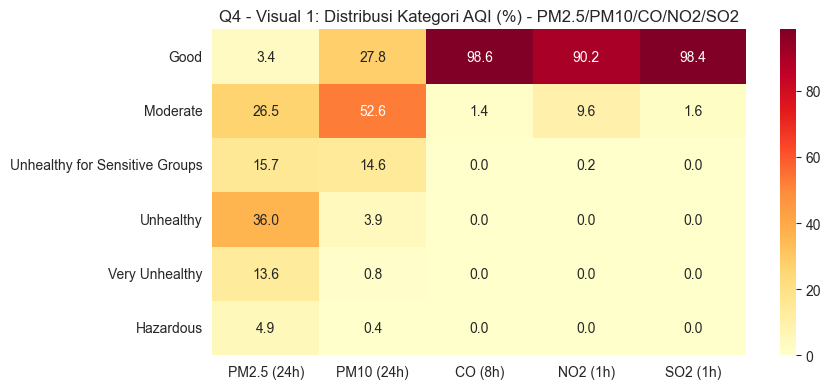

In [159]:
plt.figure(figsize=(9, 4))
sns.heatmap(summary_main, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Q4 - Visual 1: Distribusi Kategori AQI (%) - PM2.5/PM10/CO/NO2/SO2")
plt.tight_layout()
plt.show()

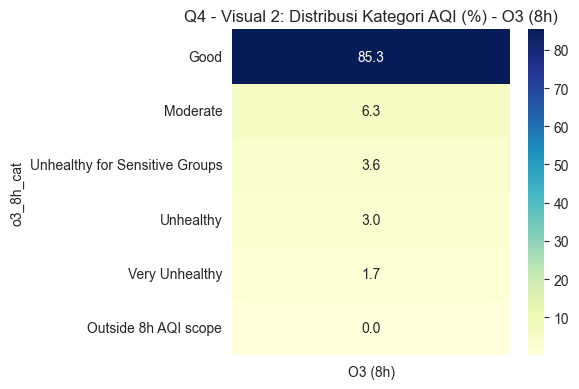

In [160]:
plt.figure(figsize=(6, 4))
sns.heatmap(o3_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Q4 - Visual 2: Distribusi Kategori AQI (%) - O3 (8h)")
plt.tight_layout()
plt.show()

### Tambahan Q4 - AQI Overall (Resmi) & Perbandingan Antar Stasiun

Blok ini menambahkan ringkasan AQI overall untuk melengkapi Q4, dengan metode resmi breakpoint AQI.

In [161]:
# Q4 - Tambahan Data: AQI overall resmi (max sub-index), bukan rata-rata 6 polutan

def subindex_series(c, breakpoints):
    out = pd.Series(np.nan, index=c.index, dtype='float64')
    for c_low, c_high, i_low, i_high in breakpoints:
        mask = (c >= c_low) & (c <= c_high)
        if mask.any():
            out.loc[mask] = ((i_high - i_low) / (c_high - c_low)) * (c.loc[mask] - c_low) + i_low
    return out.clip(lower=0, upper=500)

pm25_bp = [(0.0,12.0,0,50),(12.1,35.4,51,100),(35.5,55.4,101,150),(55.5,150.4,151,200),(150.5,250.4,201,300),(250.5,350.4,301,400),(350.5,500.4,401,500)]
pm10_bp = [(0,54,0,50),(55,154,51,100),(155,254,101,150),(255,354,151,200),(355,424,201,300),(425,504,301,400),(505,604,401,500)]
co_bp = [(0.0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.4,151,200),(15.5,30.4,201,300),(30.5,40.4,301,400),(40.5,50.4,401,500)]
no2_bp = [(0,53,0,50),(54,100,51,100),(101,360,101,150),(361,649,151,200),(650,1249,201,300),(1250,1649,301,400),(1650,2049,401,500)]
so2_bp = [(0,35,0,50),(36,75,51,100),(76,185,101,150),(186,304,151,200),(305,604,201,300),(605,804,301,400),(805,1004,401,500)]
o3_8h_bp = [(0.000,0.054,0,50),(0.055,0.070,51,100),(0.071,0.085,101,150),(0.086,0.105,151,200),(0.106,0.200,201,300)]

base_df['aqi_pm25'] = subindex_series(base_df['pm25_24h'], pm25_bp)
base_df['aqi_pm10'] = subindex_series(base_df['pm10_24h'], pm10_bp)
base_df['aqi_co'] = subindex_series(base_df['co_8h_ppm'], co_bp)
base_df['aqi_no2'] = subindex_series(base_df['no2_1h_ppb'], no2_bp)
base_df['aqi_so2'] = subindex_series(base_df['so2_1h_ppb'], so2_bp)
base_df['aqi_o3'] = subindex_series(base_df['o3_8h_ppm'], o3_8h_bp)

aqi_components = ['aqi_pm25','aqi_pm10','aqi_co','aqi_no2','aqi_so2','aqi_o3']
base_df['aqi_overall'] = base_df[aqi_components].max(axis=1, skipna=True)

bins = [-np.inf, 50, 100, 150, 200, 300, np.inf]
labels = ['Good','Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous']
base_df['aqi_overall_category'] = pd.cut(base_df['aqi_overall'], bins=bins, labels=labels)

category_order = labels
category_colors = {
    'Good':'#00e400',
    'Moderate':'#ffff00',
    'Unhealthy for Sensitive Groups':'#ff7e00',
    'Unhealthy':'#ff0000',
    'Very Unhealthy':'#8f3f97',
    'Hazardous':'#7e0023'
}

overall_dist = (base_df['aqi_overall_category'].value_counts(normalize=True)
                .reindex(category_order)
                .fillna(0)
                .mul(100)
                .round(2)
                .reset_index())
overall_dist.columns = ['Kategori AQI', 'Persentase (%)']

display(overall_dist)


,Kategori AQI,Persentase (%)
0,Good,6.67
1,Moderate,22.31
2,Unhealthy for Sensitive Groups,15.50
3,Unhealthy,41.21
4,Very Unhealthy,10.92
5,Hazardous,3.38


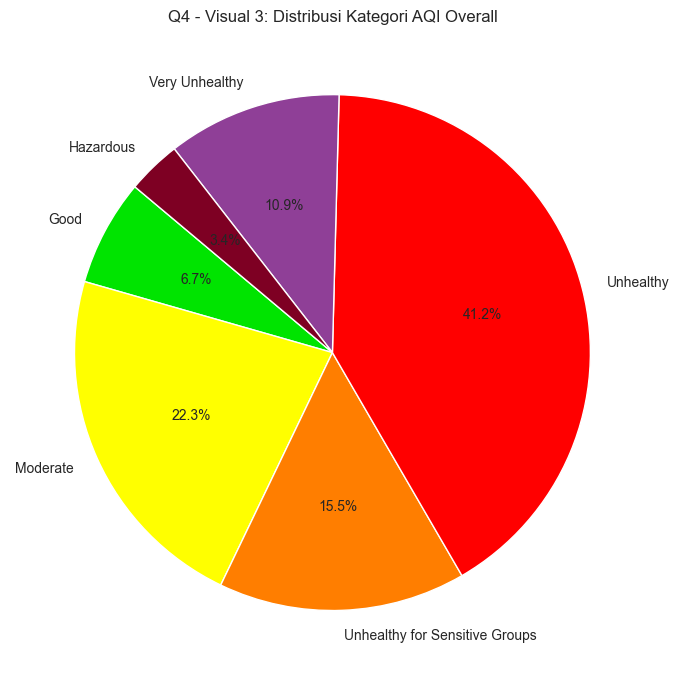

In [162]:
# Q4 - Visual 3: Distribusi Kategori AQI Overall (Pie)
plot_dist = overall_dist[overall_dist['Persentase (%)'] > 0].copy()

plt.figure(figsize=(7, 7))
plt.pie(
    plot_dist['Persentase (%)'],
    labels=plot_dist['Kategori AQI'],
    autopct='%1.1f%%',
    startangle=140,
    colors=[category_colors[c] for c in plot_dist['Kategori AQI']],
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Q4 - Visual 3: Distribusi Kategori AQI Overall')
plt.tight_layout()
plt.show()


aqi_overall_category,Good,Moderate,Unhealthy for Sensitive Groups,Unhealthy,Very Unhealthy,Hazardous
station,,,,,,
Dongsi,5.40,20.72,14.82,43.46,11.29,4.31
Wanshouxigong,5.77,19.82,15.39,43.74,11.06,4.22
Gucheng,5.05,20.56,15.42,43.99,11.17,3.80
Nongzhanguan,6.45,19.84,15.24,42.11,11.95,4.40
Wanliu,5.70,21.03,15.25,43.23,11.03,3.76
Tiantan,5.85,20.70,15.66,42.94,11.39,3.45
Guanyuan,4.88,21.54,15.84,43.54,10.55,3.65
Aotizhongxin,5.70,21.14,15.65,42.72,11.05,3.75
Shunyi,6.57,22.82,15.28,41.11,11.04,3.19


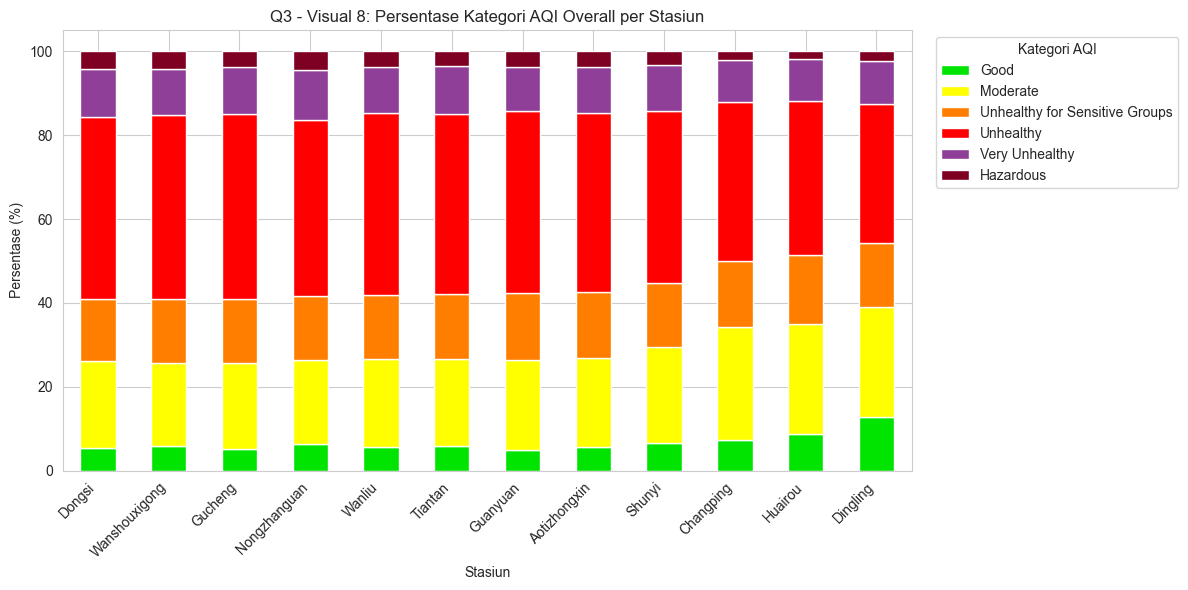

In [163]:
# Q4 - Visual 4: Komposisi Kategori AQI per Stasiun (Stacked)
station_comp = pd.crosstab(
    base_df['station'],
    base_df['aqi_overall_category'],
    normalize='index'
).mul(100).reindex(columns=category_order, fill_value=0)

station_comp['risk_score'] = station_comp[['Unhealthy','Very Unhealthy','Hazardous']].sum(axis=1)
station_comp = station_comp.sort_values('risk_score', ascending=False).drop(columns='risk_score')

display(station_comp.round(2).head(12))

ax = station_comp.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[category_colors[c] for c in station_comp.columns]
)
ax.set_title('Q4 - Visual 4: Persentase Kategori AQI Overall per Stasiun')
ax.set_xlabel('Stasiun')
ax.set_ylabel('Persentase (%)')
ax.legend(title='Kategori AQI', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [164]:
# Q4 - Tabel Tambahan: 3 Stasiun Terbaik dan Terburuk (berdasarkan AQI overall)
station_aqi = base_df.groupby('station', as_index=False)['aqi_overall'].mean().sort_values('aqi_overall')

best3 = station_aqi.head(3).copy()
worst3 = station_aqi.tail(3).sort_values('aqi_overall', ascending=False).copy()

print('3 Stasiun Terbaik (AQI terendah):')
display(best3.round(2))
print('3 Stasiun Terburuk (AQI tertinggi):')
display(worst3.round(2))


3 Stasiun Terbaik (AQI terendah):


,station,aqi_overall
2,Dingling,131.50
6,Huairou,135.60
1,Changping,137.58


3 Stasiun Terburuk (AQI tertinggi):


,station,aqi_overall
3,Dongsi,152.91
11,Wanshouxigong,152.82
7,Nongzhanguan,152.39


Insight (jawaban Q4):
- Tabel `severe_df` merangking polutan berdasarkan proporsi kategori berisiko (Unhealthy+).
- Prioritas pengendalian ditetapkan dari polutan dengan `severe_pct` tertinggi pada hasil perhitungan.
- Metode AQI overall memakai pendekatan resmi: sub-index per polutan dihitung dari breakpoint EPA, lalu AQI overall diambil dari nilai sub-index maksimum (bukan rata-rata 6 polutan).
- Tambahan visual Q4 menunjukkan distribusi kategori AQI overall (pie), komposisi kategori per stasiun (stacked), dan daftar 3 stasiun terbaik/terburuk berbasis AQI overall.


## Conclusion

Berdasarkan analisis 4 pertanyaan (2 bisnis + 2 lanjutan), temuan numerik utama adalah:

1. Q1 : PM2.5 tahunan berubah dari 86.18 (2014) ke 72.08 (2016) lalu 92.41 (2017 parsial). Tiga stasiun prioritas: Dongsi (86.14), Nongzhanguan (85.08), Wanshouxigong (85.07). Rata-rata zona: Perkotaan 83.89, Pinggiran 78.17, Perdesaan 68.17.
2. Q2 : Puncak bulan/jam polutan adalah NO2 (12 / 22:00), CO (12 / 01:00), SO2 (1 / 11:00), dan O3 (7 / 16:00).
3. Q3 : PM2.5/PM10 paling konsisten berasosiasi dengan faktor meteorologi DEWP (positif) dan WSPM (negatif), sedangkan pada gas polutan hubungan O3-TEMP paling kuat positif. Pola inti meteorologi ini tetap terlihat pada skala musim/tahun/bulan/jam.
4. Q4 : Peringkat risiko ditentukan dari `severe_df` yang mencakup PM2.5, PM10, CO, NO2, SO2, O3. AQI overall dihitung dengan metode resmi (max sub-index lintas polutan) menjadi `aqi_overall`, lalu diringkas pada distribusi kategori, komposisi per stasiun, serta tabel 3 stasiun terbaik/terburuk.

### Rekomendasi Praktis
1. Prioritaskan intervensi awal di Dongsi, Nongzhanguan, Wanshouxigong dan fokuskan kebijakan paling ketat di zona Perkotaan.
2. Fokus pengawasan emisi pada kombinasi bulan/jam puncak: Desember-Januari dan 01:00, 11:00, 16:00, 22:00.
3. Gunakan hasil asosiasi Q3 untuk sistem monitoring musiman: pantau kombinasi DEWP tinggi/WSPM rendah sebagai sinyal risiko PM meningkat, serta TEMP tinggi sebagai indikator kenaikan O3.
4. Pertahankan evaluasi AQI multi-polutan resmi (`aqi_overall`) untuk prioritas tindakan lintas stasiun.


### Menyimpan Data Bersih untuk Dashboard

In [165]:
export_cols = [
    "datetime", "station", "zone", "year", "month", "day", "hour",
    "PM2.5", "PM10", "SO2", "NO2", "CO", "O3",
    "TEMP", "PRES", "DEWP", "RAIN", "wd", "WSPM"
]

dashboard_df = clean_df[export_cols].copy()
dashboard_df.to_csv("dashboard/main_data.csv", index=False)
print(f"File dashboard/main_data.csv berhasil diperbarui: {dashboard_df.shape}")
print("Kolom yang diekspor:", dashboard_df.columns.tolist())
display(dashboard_df.head())

File dashboard/main_data.csv berhasil diperbarui: (420768, 19)
Kolom yang diekspor: ['datetime', 'station', 'zone', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']


,datetime,station,zone,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013-03-01 00:00:00,Aotizhongxin,Perkotaan,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013-03-01 01:00:00,Aotizhongxin,Perkotaan,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013-03-01 02:00:00,Aotizhongxin,Perkotaan,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013-03-01 03:00:00,Aotizhongxin,Perkotaan,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013-03-01 04:00:00,Aotizhongxin,Perkotaan,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0
